# Mount Google Drive & Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# Load CSV files
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load & Filter train.csv in Chunks


In [2]:
# Load train.csv in chunks
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=1000000)

# Filter stores in 'Guayas' state
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Filter selected item families
item_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']
items_ids = df_items[df_items['family'].isin(item_families)]['item_nbr'].unique()

filtered_chunks = []

# Process each chunk
for chunk in df_train:
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(items_ids))]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory

# Combine all filtered chunks
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up memory
del filtered_chunks

df_train.head()

<ipython-input-2-4cec2d5a838d>:14: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df_train:


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18790,2013-01-02,24,105574,12.0,NaN
1,18791,2013-01-02,24,105575,2.0,NaN
2,18792,2013-01-02,24,105577,1.0,NaN
3,18793,2013-01-02,24,105693,7.0,NaN
4,18794,2013-01-02,24,105737,17.0,NaN


# Handle Missing Values

In [3]:
# Check missing values
print("Missing values before handling:")

print(df_train.isna().sum(),'\n')
print(df_oil.isna().sum(),'\n')
print(df_transactions.isna().sum(),'\n')
print(df_holidays_events.isna().sum(),'\n')
print(df_items.isna().sum(),'\n')
print(df_stores.isna().sum(),'\n')

# Fill missing values in `onpromotion` column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

# Fill missing values in `oil` dataset
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].bfill()

print("Missing values after handling:")
print(df_train.isna().sum(),'\n')
print(df_oil.isna().sum(),'\n')


Missing values before handling:
id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64 

date           0
dcoilwtico    43
dtype: int64 

date            0
store_nbr       0
transactions    0
dtype: int64 

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64 

item_nbr      0
family        0
class         0
perishable    0
dtype: int64 

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 



<ipython-input-3-6d4ff8b59f05>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


Missing values after handling:
id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64 

date          0
dcoilwtico    0
dtype: int64 



# Filter Data for Jan-March 2014

In [4]:
# Convert 'date' column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Filter dataset for Jan-Mar 2014
df_train = df_train[(df_train['date'] >= '2014-01-01') & (df_train['date'] <= '2014-03-31')]

print(f"Filtered dataset shape: {df_train.shape}")
df_train.head()

Filtered dataset shape: (629145, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
2118130,16323658,2014-01-01,36,96995,1.0,False
2118131,16323660,2014-01-01,36,105576,4.0,False
2118132,16323661,2014-01-01,36,105693,1.0,False
2118133,16323662,2014-01-01,36,106716,3.0,False
2118134,16323665,2014-01-01,36,108786,1.0,False


# Handle Negative Sales (Returns)

In [5]:
# Identify negative sales
negative_sales = df_train[df_train['unit_sales'] < 0]
print("Negative sales before correction:")
print(negative_sales.head())

# Replace negative sales with 0 (treat returns as no sales)
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

# Verify correction
negative_sales = df_train[df_train['unit_sales'] < 0]
print("Negative sales after correction:")
print(negative_sales.head())

Negative sales before correction:
               id       date  store_nbr  item_nbr  unit_sales  onpromotion
2173113  16812790 2014-01-09         27   1464034      -2.000        False
2176843  16820878 2014-01-09         36   1124165      -3.000        False
2177228  16841624 2014-01-09         51    374464     -11.000        False
2185332  16936170 2014-01-11         24    885553      -3.000        False
2189257  16945517 2014-01-11         32   1391408      -0.495        False
Negative sales after correction:
Empty DataFrame
Columns: [id, date, store_nbr, item_nbr, unit_sales, onpromotion]
Index: []


# Check Unique Stores & Items

In [6]:
print(f"Unique stores in filtered data: {df_train['store_nbr'].nunique()} / {df_stores['store_nbr'].nunique()}")
print(f"Unique items in filtered data: {df_train['item_nbr'].nunique()} / {df_items['item_nbr'].nunique()}")

Unique stores in filtered data: 10 / 54
Unique items in filtered data: 1439 / 4100


# Detect Outliers Using Z-Score

In [7]:
# Compute mean and standard deviation for store-item groups
mean_sales = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('mean')
std_sales = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('std')

# Avoid division by zero
std_sales = std_sales.replace(0, 1).fillna(1)

# Calculate Z-score
df_train['z_score'] = (df_train['unit_sales'] - mean_sales) / std_sales

# Detect outliers (Z-score > 5)
outliers = df_train[df_train['z_score'] > 5]
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 752


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
2118730,16352845,2014-01-02,24,165988,51.0,False,5.783188
2118872,16353027,2014-01-02,24,360703,56.0,False,5.592084
2120775,16357607,2014-01-02,27,956013,63.0,False,5.351105
2121737,16359167,2014-01-02,28,1145597,19.0,False,5.106429
2121967,16359667,2014-01-02,30,165693,43.0,False,6.672245


# Find Missing Dates in Dataset

In [8]:
# Get min and max dates
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Create a full date range
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Find missing dates
existing_dates = pd.to_datetime(df_train['date']).sort_values().unique()
missing_dates = sorted(set(full_date_range) - set(existing_dates))

print("Missing Dates:", missing_dates)

Missing Dates: []


# Feature Engineering

In [10]:
# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [20]:
df_train['unit_sales_7d_avg'].nunique()

1419

In [21]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg
2118130,16323658,2014-01-01,36,96995,1.0,False,-0.641759,2014,1,1,2,NaN
2118131,16323660,2014-01-01,36,105576,4.0,False,-0.882058,2014,1,1,2,NaN
2118132,16323661,2014-01-01,36,105693,1.0,False,-1.133008,2014,1,1,2,NaN
2118133,16323662,2014-01-01,36,106716,3.0,False,-0.894551,2014,1,1,2,NaN
2118134,16323665,2014-01-01,36,108786,1.0,False,-1.359477,2014,1,1,2,NaN


# Visualizing Data



More detailed analysis for data from Guayas region.
* How many stores it has?
* What are the largest stores (with the most items sold)
* How often are new items introduced in the stores of Guayas region? What are these items (family, class, etc)?
* Look at the time-series for item-store pair of top-seller items. Do you observe any seasonality or trend there? Are the sales the same from one year to another?


In [23]:
stores_in_guayas = df_stores[df_stores['state']=='Guayas']
print(f"Number of stores in Guayas: {len(stores_in_guayas)}")

Number of stores in Guayas: 11


In [29]:
stores_in_guayas['store_nbr'].unique()

array([24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51])

In [30]:
stores_in_guayas

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
25,26,Guayaquil,Guayas,D,10
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
28,29,Guayaquil,Guayas,E,10
29,30,Guayaquil,Guayas,C,3
31,32,Guayaquil,Guayas,C,3
33,34,Guayaquil,Guayas,B,6
34,35,Playas,Guayas,C,3
35,36,Libertad,Guayas,E,10


In [55]:
# How many products are sold in stores on average?
store_numbers=df_train['store_nbr'].unique()

In [51]:
store_sales = df_train.groupby('store_nbr')['unit_sales'].mean()

In [57]:
store_sales

,unit_sales
store_nbr,
24,9.030371
26,4.446645
27,6.862901
28,7.318199
30,4.598762
32,4.220516
34,8.914662
35,6.101020
36,6.916150


<ipython-input-61-ab671eac4d93>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=store_sales.index, y=store_sales.values, palette='viridis')


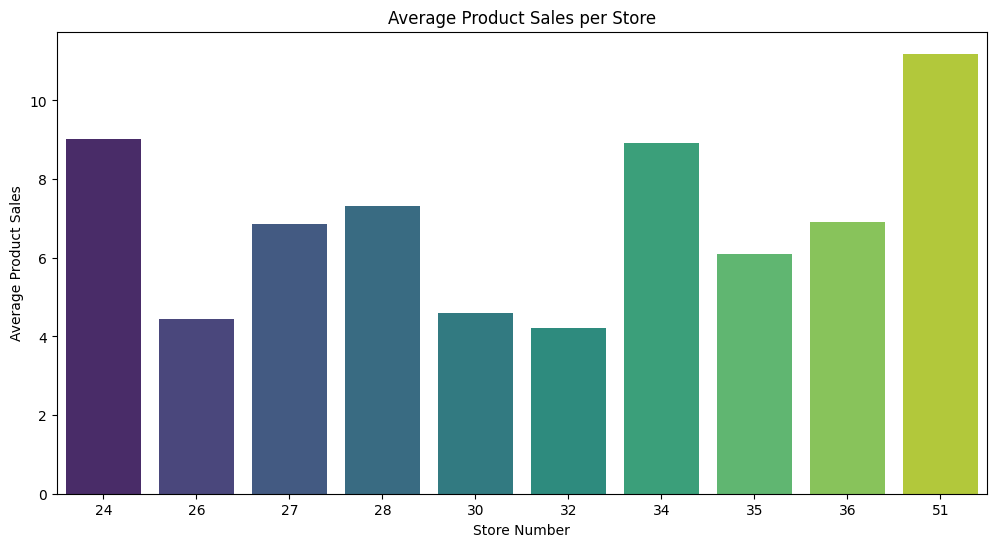

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index, y=store_sales.values, palette='viridis')
plt.title('Average Product Sales per Store')
plt.ylabel('Average Product Sales')
plt.xlabel('Store Number')
plt.show()